# CNN Model

In [1]:
import os, sys, math, time, json, random
from pathlib import Path
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps, ImageEnhance
from torchvision import datasets, models
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns

# 1. Data Loader

In [2]:
batch_size = 32
img_size = 224
epochs = 20
lr = 3e-4
weight_decay = 1e-4
num_workers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

data_dir = "/kaggle/input/chilli-dataset/Mehedi2"

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val", "test"]
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ["train", "val", "test"]
}

class_names = image_datasets["train"].classes
print("Classes:", class_names)

Classes: ['cercospora', 'healthy', 'mites_and_trips', 'nutritional', 'powdery mildew']


# 2. Display some augmented images

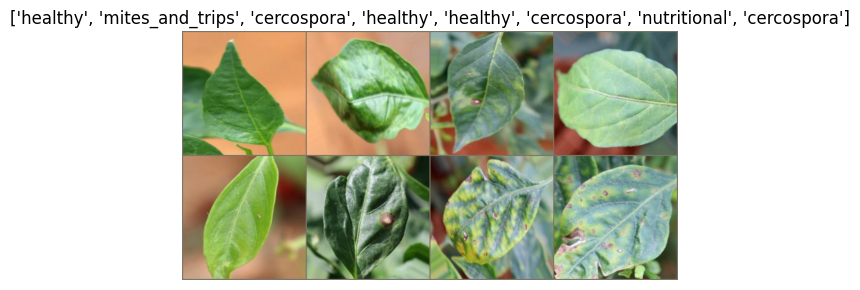

In [4]:
def imshow(inp, title=None):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    inp = inp * std[:, None, None] + mean[:, None, None]

    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_batch(loader):
    inputs, classes = next(iter(loader))
    out = torchvision.utils.make_grid(inputs[:8], nrow=4)
    imshow(out, title=[class_names[x] for x in classes[:8]])

show_batch(dataloaders['test'])

# 3. Custom CNN

In [5]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 4. Early Stopping

In [6]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best = float('inf')
        self.early_stop = False
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

early_stopping = EarlyStopping(patience=3, min_delta=1e-4)

# 5. Configuration

In [7]:
num_classes = len(class_names)
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(enabled=(device.type == "cuda"))

/tmp/ipykernel_19/2207579422.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


# 6. Training using Custom CNN (Using AMP)

In [8]:
train_losses, val_losses, val_f1s = [], [], []
best_f1 = -1.0
best_path = "custom_cnn_best.pth"
y_true, y_pred = [], []

def run_epoch(loader, model, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0

    pbar = tqdm(loader, total=len(loader))
    for images, labels in pbar:
        images = images.to(device, non_blocking=True).float()
        labels = torch.as_tensor(labels, device=device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1).detach().cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())

    epoch_loss = running_loss / len(loader.dataset)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    f1 = report['weighted avg']['f1-score']
    return epoch_loss, f1, report

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    tr_loss, tr_f1, _ = run_epoch(dataloaders["train"], model, train=True)
    with torch.no_grad():
        val_loss, val_f1, val_report = run_epoch(dataloaders["val"], model, train=False)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)

    scheduler.step(val_loss)

    print(f"  train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_f1={val_f1:.4f} | lr={optimizer.param_groups[0]['lr']:.2e}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), best_path)
        print(f" New best F1: {best_f1:.4f} — saved to {best_path}")

    if early_stopping.step(val_loss):
        print(" Early stopping triggered.")
        break

Epoch 1/20


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


  train_loss=0.9959 | val_loss=1.0020 | val_f1=0.6245 | lr=3.00e-04
 New best F1: 0.6245 — saved to custom_cnn_best.pth
Epoch 2/20


100%|██████████| 69/69 [00:04<00:00, 14.05it/s]


  train_loss=0.5925 | val_loss=0.7575 | val_f1=0.6877 | lr=3.00e-04
 New best F1: 0.6877 — saved to custom_cnn_best.pth
Epoch 3/20


100%|██████████| 69/69 [00:05<00:00, 13.58it/s]


  train_loss=0.4782 | val_loss=1.0392 | val_f1=0.7151 | lr=3.00e-04
 New best F1: 0.7151 — saved to custom_cnn_best.pth
Epoch 4/20


100%|██████████| 69/69 [00:05<00:00, 13.30it/s]


  train_loss=0.4157 | val_loss=0.7318 | val_f1=0.7408 | lr=3.00e-04
 New best F1: 0.7408 — saved to custom_cnn_best.pth
Epoch 5/20


100%|██████████| 69/69 [00:04<00:00, 14.24it/s]


  train_loss=0.3450 | val_loss=0.9330 | val_f1=0.7570 | lr=3.00e-04
 New best F1: 0.7570 — saved to custom_cnn_best.pth
Epoch 6/20


100%|██████████| 69/69 [00:05<00:00, 13.49it/s]


  train_loss=0.3106 | val_loss=0.9839 | val_f1=0.7708 | lr=3.00e-04
 New best F1: 0.7708 — saved to custom_cnn_best.pth
Epoch 7/20


100%|██████████| 69/69 [00:04<00:00, 13.95it/s]


  train_loss=0.2809 | val_loss=0.5290 | val_f1=0.7857 | lr=3.00e-04
 New best F1: 0.7857 — saved to custom_cnn_best.pth
Epoch 8/20


100%|██████████| 69/69 [00:04<00:00, 13.96it/s]


  train_loss=0.2573 | val_loss=0.3829 | val_f1=0.7992 | lr=3.00e-04
 New best F1: 0.7992 — saved to custom_cnn_best.pth
Epoch 9/20


100%|██████████| 69/69 [00:05<00:00, 13.70it/s]


  train_loss=0.2304 | val_loss=0.5086 | val_f1=0.8094 | lr=3.00e-04
 New best F1: 0.8094 — saved to custom_cnn_best.pth
Epoch 10/20


100%|██████████| 69/69 [00:04<00:00, 13.82it/s]


  train_loss=0.1981 | val_loss=0.3512 | val_f1=0.8199 | lr=3.00e-04
 New best F1: 0.8199 — saved to custom_cnn_best.pth
Epoch 11/20


100%|██████████| 69/69 [00:05<00:00, 13.40it/s]


  train_loss=0.1784 | val_loss=0.4768 | val_f1=0.8281 | lr=3.00e-04
 New best F1: 0.8281 — saved to custom_cnn_best.pth
Epoch 12/20


100%|██████████| 69/69 [00:04<00:00, 13.88it/s]


  train_loss=0.1585 | val_loss=0.2986 | val_f1=0.8369 | lr=3.00e-04
 New best F1: 0.8369 — saved to custom_cnn_best.pth
Epoch 13/20


100%|██████████| 69/69 [00:04<00:00, 14.16it/s]


  train_loss=0.1577 | val_loss=0.5168 | val_f1=0.8429 | lr=3.00e-04
 New best F1: 0.8429 — saved to custom_cnn_best.pth
Epoch 14/20


100%|██████████| 69/69 [00:05<00:00, 13.60it/s]


  train_loss=0.1600 | val_loss=0.2299 | val_f1=0.8496 | lr=3.00e-04
 New best F1: 0.8496 — saved to custom_cnn_best.pth
Epoch 15/20


100%|██████████| 69/69 [00:04<00:00, 14.03it/s]


  train_loss=0.1475 | val_loss=0.4813 | val_f1=0.8544 | lr=3.00e-04
 New best F1: 0.8544 — saved to custom_cnn_best.pth
Epoch 16/20


100%|██████████| 69/69 [00:04<00:00, 14.10it/s]


  train_loss=0.1289 | val_loss=0.1966 | val_f1=0.8603 | lr=3.00e-04
 New best F1: 0.8603 — saved to custom_cnn_best.pth
Epoch 17/20


100%|██████████| 69/69 [00:04<00:00, 13.95it/s]


  train_loss=0.1216 | val_loss=0.2597 | val_f1=0.8654 | lr=3.00e-04
 New best F1: 0.8654 — saved to custom_cnn_best.pth
Epoch 18/20


100%|██████████| 69/69 [00:04<00:00, 14.11it/s]


  train_loss=0.1212 | val_loss=0.2753 | val_f1=0.8701 | lr=3.00e-04
 New best F1: 0.8701 — saved to custom_cnn_best.pth
Epoch 19/20


100%|██████████| 69/69 [00:04<00:00, 14.01it/s]


  train_loss=0.1159 | val_loss=0.2786 | val_f1=0.8741 | lr=3.00e-04
 New best F1: 0.8741 — saved to custom_cnn_best.pth
 Early stopping triggered.


# 7. Plotting Loss Curve

100%|██████████| 70/70 [00:08<00:00,  8.13it/s]


Test F1: 0.8743344642400831
{
  "0": {
    "precision": 0.8873071847348722,
    "recall": 0.8128344365611003,
    "f1-score": 0.8484397141113559,
    "support": 50458
  },
  "1": {
    "precision": 0.8377659079488563,
    "recall": 0.8982678799489144,
    "f1-score": 0.8669626262723534,
    "support": 50112
  },
  "2": {
    "precision": 0.8726629190089528,
    "recall": 0.8989983484546255,
    "f1-score": 0.8856348979958375,
    "support": 46623
  },
  "3": {
    "precision": 0.8475044134167871,
    "recall": 0.798644929070506,
    "f1-score": 0.8223495702005731,
    "support": 33061
  },
  "4": {
    "precision": 0.9454002808988764,
    "recall": 0.977284413659599,
    "f1-score": 0.9610779778990733,
    "support": 33061
  },
  "accuracy": 0.8750251974779083,
  "macro avg": {
    "precision": 0.8781281412016689,
    "recall": 0.877206001538949,
    "f1-score": 0.8768929572958386,
    "support": 213315
  },
  "weighted avg": {
    "precision": 0.8753029860919758,
    "recall": 0.87502

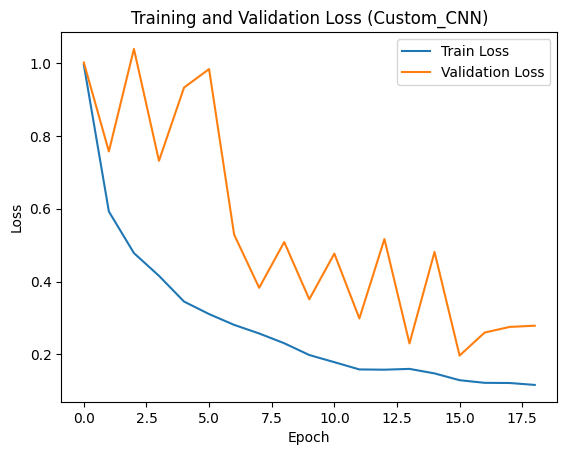

In [9]:
if Path(best_path).exists():
    model.load_state_dict(torch.load(best_path, map_location=device))

with torch.no_grad():
    test_loss, test_f1, test_report = run_epoch(dataloaders["test"], model, train=False)

print("Test F1:", test_f1)
print(json.dumps(test_report, indent=2))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss (Custom_CNN)")
plt.show()

# 8. Confusion Matrix

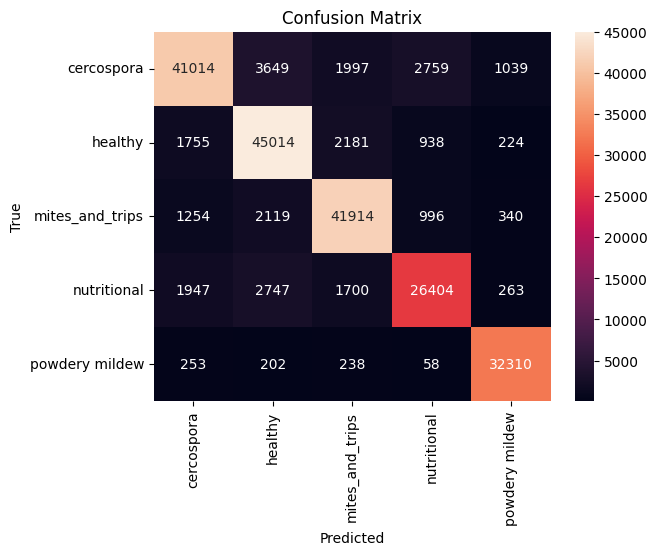

                 precision    recall  f1-score   support

     cercospora       0.89      0.81      0.85     50458
        healthy       0.84      0.90      0.87     50112
mites_and_trips       0.87      0.90      0.89     46623
    nutritional       0.85      0.80      0.82     33061
 powdery mildew       0.95      0.98      0.96     33061

       accuracy                           0.88    213315
      macro avg       0.88      0.88      0.88    213315
   weighted avg       0.88      0.88      0.87    213315



In [10]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))